In [ ]:
#빅데이터_분석&시각화 #미니실습,

# 1. 군집합(비지도학습 분석),
# UCI 정제된 데이터, 영국 쇼핑몰, 붓꽃 데이터를 이용했음.
#
# UCI 다른 데이터 셋을 이용해서, 군집합 분석 해보기.
# 군을 나누는 기법, 1) 엘보 기법 2) 실루엣 계수 이용법,
# 2가지 중 1가지 이상 이용해서, 예측 해보기.
# k-means 알고리즘 이용해서, 예측 해보기.
# 모델 만들고, 샘플 값 이용해서, 예측 해보기.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# 1. 데이터 로드 및 전처리
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
df = pd.read_csv(url, header=None)

# 컬럼명 추가 (UCI 문서 참고)
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df.columns = columns

# 데이터 저장 (XLSX 파일로 변환)
df.to_excel("heart_disease.xlsx", index=False)

# '?' 값을 NaN으로 변환 후 숫자로 변환
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# 결측치 확인 및 제거
df.dropna(inplace=True)

# 'target' 컬럼 제거 (군집화에 필요 없음)
df_features = df.drop(columns=['target'])

# 특성 스케일링
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

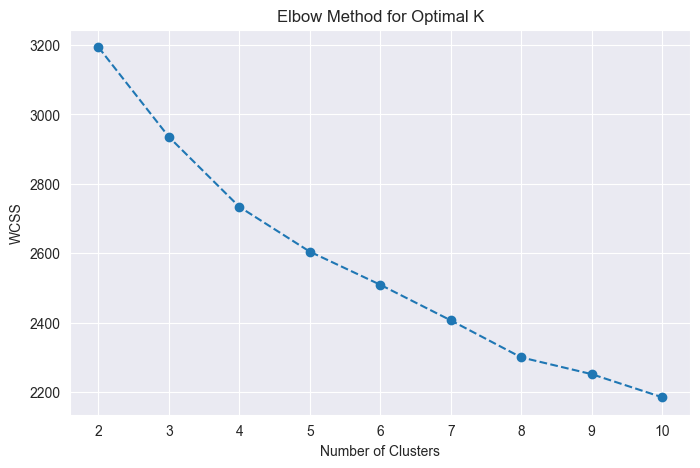

In [5]:
# 2. 최적 군집 수 결정 - 엘보 기법
wcss = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

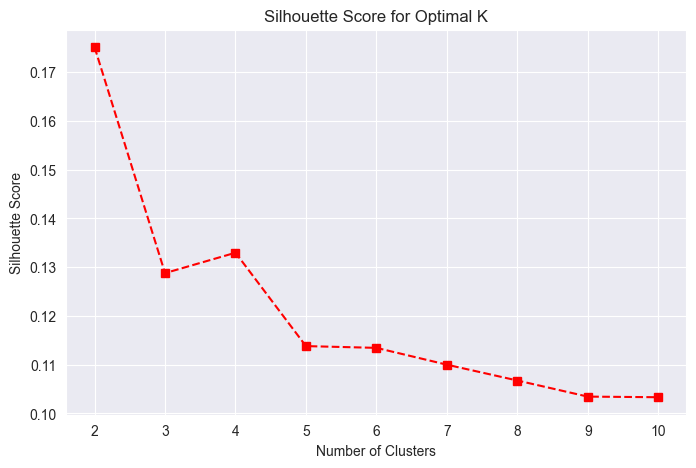

In [6]:
# 3. 최적 군집 수 결정 - 실루엣 계수
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='s', linestyle='--', color='r')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

In [7]:
# 4. K-means 모델 학습 (최적 K 설정 필요)
optimal_k = 3  # 엘보 기법 & 실루엣 계수를 통해 결정 (변경 가능)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(df_scaled)
labels = kmeans.labels_

df['Cluster'] = labels  # 원본 데이터에 군집 정보 추가

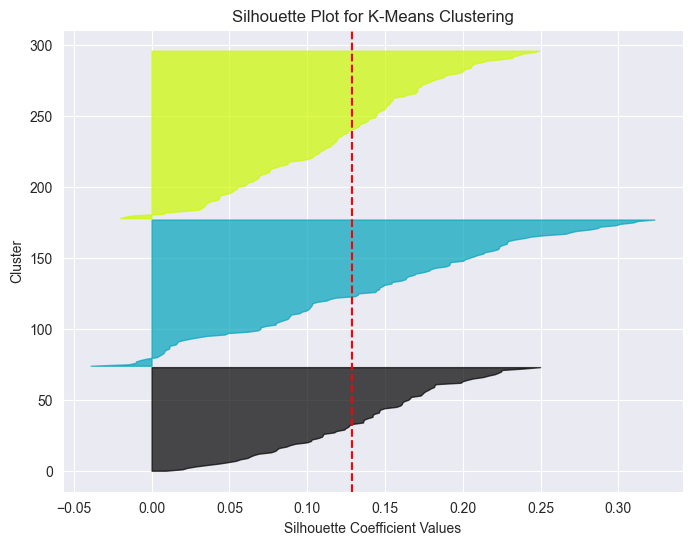

In [8]:
# 5. 실루엣 계수 시각화
def plot_silhouette(X, labels):
    n_clusters = len(set(labels))
    silhouette_vals = silhouette_samples(X, labels)
    y_lower, y_upper = 0, 0

    plt.figure(figsize=(8, 6))
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper

    plt.axvline(x=silhouette_score(X, labels), color="red", linestyle="--")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster")
    plt.title("Silhouette Plot for K-Means Clustering")
    plt.show()

plot_silhouette(df_scaled, labels)

In [10]:
# 6. 새로운 샘플 데이터 예측
# 새로운 샘플 데이터 (데이터프레임 변환)
new_sample = pd.DataFrame([[63, 1, 3, 145, 233, 1, 0, 150, 0, 2.3, 0, 0, 1]],
                          columns=df_features.columns)  # 기존 데이터와 동일한 컬럼명 유지

# 동일한 스케일 적용
new_sample_scaled = scaler.transform(new_sample)

# 클러스터 예측
predicted_cluster = kmeans.predict(new_sample_scaled)
print(f"The new sample belongs to cluster {predicted_cluster[0]}")


The new sample belongs to cluster 2


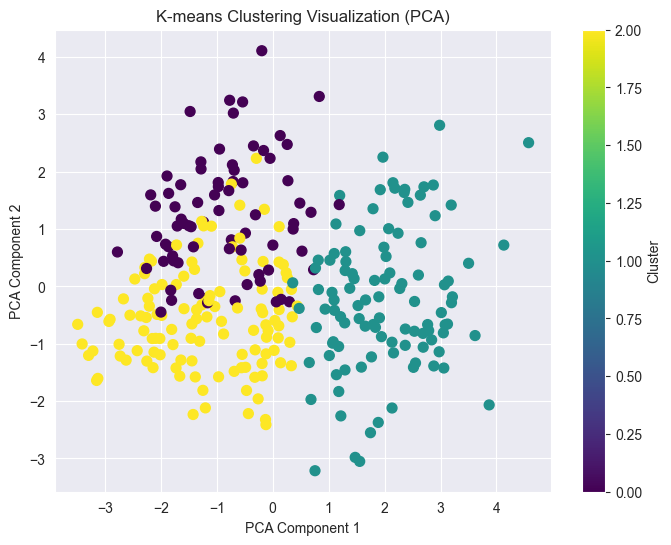

In [11]:
from sklearn.decomposition import PCA

# 7. K-means 군집 시각화 (PCA를 사용하여 2D로 축소)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# 군집 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('K-means Clustering Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()